# 作业要求：
	1.补全网络代码，并运行手写数字识别项目。以出现最后的图片和预测结果为准。（65分）
   2.保留原本的multilayer_perceptron网络定义（自己补全完的），自己定义一个卷积网络并运行成功。以出现最后的图片和预测结果为准（45分）

首先导入必要的包

numpy---------->python第三方库，用于进行科学计算

PIL------------> Python Image Library,python第三方图像处理库

matplotlib----->python的绘图库 pyplot:matplotlib的绘图框架

os------------->提供了丰富的方法来处理文件和目录

In [1]:
#导入需要的包
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import paddle
print("本教程基于Paddle的版本号为："+paddle.__version__)

本教程基于Paddle的版本号为：2.0.1


# **Step1：准备数据。**

(1)数据集介绍

MNIST数据集包含60000个训练集和10000测试数据集。分为图片和标签，图片是28*28的像素矩阵，标签为0~9共10个数字。

![](https://ai-studio-static-online.cdn.bcebos.com/fc73217ae57f451a89badc801a903bb742e42eabd9434ecc8089efe19a66c076)

(2)transform函数是定义了一个归一化标准化的标准

(3)train_dataset和test_dataset

paddle.vision.datasets.MNIST()中的mode='train'和mode='test'分别用于获取mnist训练集和测试集

transform=transform参数则为归一化标准

In [2]:
#导入数据集Compose的作用是将用于数据集预处理的接口以列表的方式进行组合。
#导入数据集Normalize的作用是图像归一化处理，支持两种方式： 1. 用统一的均值和标准差值对图像的每个通道进行归一化处理； 2. 对每个通道指定不同的均值和标准差值进行归一化处理。
from paddle.vision.transforms import Compose, Normalize
transform = Compose([Normalize(mean=[127.5],std=[127.5],data_format='CHW')])
# 使用transform对数据集做归一化
print('下载并加载训练数据')
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)
print('加载完成')

下载并加载训练数据


Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz 
Begin to download
..
Download finished


加载完成


AxesImage(18,18;111.6x108.72)
train_data0 的标签为: [5]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


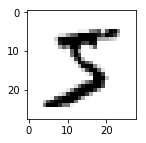

In [3]:
#让我们一起看看数据集中的图片是什么样子的
train_data0, train_label_0 = train_dataset[0][0],train_dataset[0][1]
train_data0 = train_data0.reshape([28,28])
plt.figure(figsize=(2,2))
print(plt.imshow(train_data0, cmap=plt.cm.binary))
print('train_data0 的标签为: ' + str(train_label_0))

In [4]:
#让我们再来看看数据样子是什么样的吧
print(train_data0)

[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.  

# **Step2.网络配置**
以下的代码判断就是定义一个简单的多层感知器，一共有三层，两个大小为100的隐层和一个大小为10的输出层，因为MNIST数据集是手写0到9的灰度图像，类别有10个，所以最后的输出大小是10。最后输出层的激活函数是Softmax，所以最后的输出层相当于一个分类器。加上一个输入层的话，多层感知器的结构是：输入层-->>隐层-->>隐层-->>输出层。

![](https://ai-studio-static-online.cdn.bcebos.com/cb69f928778c4299b75814179607a89eea770bdc409d4e08a87e2975cb96b19b)

# 请补全网络代码

In [ ]:
import paddle
import paddle.nn.functional as F
from paddle.vision.transforms import ToTensor

In [ ]:
# 定义多层感知器 
#动态图定义多层感知器
class multilayer_perceptron(paddle.nn.Layer):
    def __init__(self):
        super(multilayer_perceptron,self).__init__()
        #请在这里补全网络代码
        self.flatten = paddle.nn.Flatten()
        self.hidden = paddle.nn.Linear(in_features=784,out_features=128)
        self.output = paddle.nn.Linear(in_features=128,out_features=10)

    def forward(self, x):
        #请在这里补全传播过程的代码
        x = self.flatten(x)
        x = self.hidden(x)
        x = F.relu(x)
        y = self.output(x)

        return y

# 卷积LeNet（另外几种方式定义网络）

In [ ]:
import paddle.nn as nn

In [ ]:
LeNet1 = nn.Sequential(
    nn.Conv2D(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2D(kernel_size=2, stride=2),
    nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2D(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=400, out_features=120),  # 400 = 5x5x16，输入形状为32x32， 输入形状为28x28时调整为256
    nn.Linear(in_features=120, out_features=84),
    nn.Linear(in_features=84, out_features=10)
)

In [ ]:
#请在这里定义卷积网络的代码
class LeNet2(nn.Layer):

    def __init__(self, num_classes=10):
        """
        初始化函数
        """
        super(LeNet2, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2D(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),  # 第一层卷积
            nn.ReLU(), # 激活函数
            nn.MaxPool2D(kernel_size=2, stride=2),  # 最大池化，下采样
            nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0), # 第二层卷积
            nn.ReLU(), # 激活函数
            nn.MaxPool2D(kernel_size=2, stride=2) # 最大池化，下采样
        )

        self.fc = nn.Sequential(
            nn.Linear(400, 120),  # 全连接
            nn.Linear(120, 84),   # 全连接
            nn.Linear(84, num_classes) # 输出层
        )

    def forward(self, inputs):
        
        y = self.features(inputs)
        y = paddle.flatten(y, 1)
        out = self.fc(y)

        return out

LeNet = LeNet2()

#注意：定义完成卷积的代码后，后面的代码是需要修改的！

In [ ]:
# 高层API的使用
LeNet3 = paddle.vision.models.LeNet(num_classes=10)

In [ ]:
paddle.summary(LeNet,(1, 1, 28, 28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-3       [[1, 1, 28, 28]]      [1, 6, 28, 28]          60       
    ReLU-3        [[1, 6, 28, 28]]      [1, 6, 28, 28]           0       
  MaxPool2D-3     [[1, 6, 28, 28]]      [1, 6, 14, 14]           0       
   Conv2D-4       [[1, 6, 14, 14]]     [1, 16, 10, 10]         2,416     
    ReLU-4       [[1, 16, 10, 10]]     [1, 16, 10, 10]           0       
  MaxPool2D-4    [[1, 16, 10, 10]]      [1, 16, 5, 5]            0       
   Linear-4          [[1, 400]]            [1, 120]           48,120     
   Linear-5          [[1, 120]]            [1, 84]            10,164     
   Linear-6          [[1, 84]]             [1, 10]              850      
Total params: 61,610
Trainable params: 61,610
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward

{'total_params': 61610, 'trainable_params': 61610}

In [ ]:
# from paddle.metric import Accuracy

# # 用Model封装模型
# model = paddle.Model(multilayer_perceptron())  

# # 定义损失函数
# optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())

# # 配置模型
# model.prepare(optim,paddle.nn.CrossEntropyLoss(),Accuracy())

# # 训练保存并验证模型
# model.fit(train_dataset,test_dataset,epochs=2,batch_size=64,save_dir='multilayer_perceptron',verbose=1)

In [ ]:
# 模型封装
model = paddle.Model(LeNet)

# 模型配置
model.prepare(paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters()), # 优化器
              paddle.nn.CrossEntropyLoss(), # 损失函数
              paddle.metric.Accuracy()) # 评估指标

# 训练可视化VisualDL工具的回调函数
visualdl = paddle.callbacks.VisualDL(log_dir='visualdl_log')

# 启动全流程训练
model.fit(train_dataset,  # 训练数据集
          epochs=5,       # 训练轮次
          batch_size=64,  # 单次计算数据样本量
          verbose=1,      # 日志展示形式
          save_dir='./chk_points/', # 分阶段的训练模型存储路径
          callbacks=[visualdl])    #可视化  

# 模型评估
result = model.evaluate(test_dataset, verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/5
step  10/938 [..............................] - loss: 1.9027 - acc: 0.2031 - ETA: 40s - 44ms/step

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


step  20/938 [..............................] - loss: 1.0030 - acc: 0.3867 - ETA: 24s - 26ms/stepstep 938/938 [==============================] - loss: 0.0473 - acc: 0.9387 - 9ms/step         
save checkpoint at /home/aistudio/chk_points/0
Epoch 2/5
step 880/938 [===========================>..] - loss: 0.0366 - acc: 0.9741 - ETA: 0s - 10ms/st

In [ ]:
#获取测试集的第一个图片
test_data0, test_label_0 = test_dataset[0][0],test_dataset[0][1]
test_data0 = test_data0.reshape([28,28])
plt.figure(figsize=(2,2))
#展示测试集中的第一个图片
print(plt.imshow(test_data0, cmap=plt.cm.binary))
print('test_data0 的标签为: ' + str(test_label_0))
#模型预测
result = model.predict(test_dataset, batch_size=1)
#打印模型预测的结果
print('test_data0 预测的数值为：%d' % np.argsort(result[0][0])[0][-1])